# Naive Bayes For Suicide and Depression Posts Detection

## Description about dataset

* This dataset, Suicide_Detection dataset, is a collection of reddit posts from "SuicideWatch" and "depression" subreddits of the Reddit platform. 
* It mainly contains two features: the original text of the posts, and whether this post contains a suicide tendency.
* This dataset is found on Kaggle. Reddit posts in this dataset were originally using Pushshift API. 
* All posts that were made to "SuicideWatch" from Dec 16, 2008(creation) till Jan 2, 2021, were collected while "depression" posts were collected from Jan 1, 2009, to Jan 2, 2021.
* There are two classes in this dataset: suicide refers to the Reddit posts that contains a suicide tendancy, while non-suicide refers to the normal Reddit posts
* The reason why I choose this dataset is that, if we are able to build a effective classifier that detect people's suicide tendancy through their online posts, we might help intervene these people in a timely manner and prevent them from committing suicide, which I believe is rather meaningful.

The source of this dataset can be found through this link: https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch

## Research Question & Goal

* Research Question: Build a supervised machine learning model and conduct classification on the original texts of reddit posts, predict whether a reddit post belongs to the 'suicide' or 'non-suicide' category
* Goal: Hopefully we can build a model that can effectively predict whether a reddit post contains any suicide tendency, so that we might help interfere and prevent their posters from committing suicide in the future

## Why Naive Bayes?

* Naive Bayes is based on Bayes Theorem, which provides conditional probability of the occurence of the two targetting events: "non-suicide" and "suicide" based on the probability of occurence of each individual words. 
* Naive Bayes assumes that each word is independent from each other, which largely simplify the computation process.
* Therefore, Naive Bayes is a good way of answering the research question

## Modeling with Naive Bayes

Read in the data and conduct exploratory analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Suicide_Detection.csv', index_col = 0)
df.head()

,text,class
2,Ex Wife Threatening SuicideRecently I left my ...,suicide
3,Am I weird I don't get affected by compliments...,non-suicide
4,Finally 2020 is almost over... So I can never ...,non-suicide
8,i need helpjust help me im crying so hard,suicide
9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [2]:
# The dataset contains two variables / columns
# text: posts from reddit
# class: Whether the text contains suicide ideation
df.describe()

,text,class
count,232074,232074
unique,232074,2
top,Ex Wife Threatening SuicideRecently I left my ...,suicide
freq,1,116037


                  0
class              
non-suicide  116037
suicide      116037


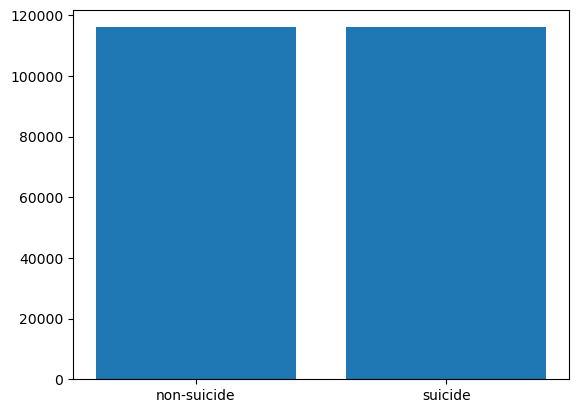

In [3]:
# Half of the text data in the dataset contains suicide tendency, while the other half do not
df_type = pd.DataFrame(df.groupby('class').size())
print(df_type)

plt.bar(df_type.index, df_type[0])
plt.show()

Conduct data cleaning

In [4]:
# Standardize class column: 1 -- suicide, 0 -- non-suicide
df.loc[df['class'] == 'non-suicide', ['class']] = 0
df.loc[df['class'] == 'suicide', ['class']] = 1
df['class'] = df['class'].astype('int')
df.head()

,text,class
2,Ex Wife Threatening SuicideRecently I left my ...,1
3,Am I weird I don't get affected by compliments...,0
4,Finally 2020 is almost over... So I can never ...,0
8,i need helpjust help me im crying so hard,1
9,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [5]:
# Clean the text data
import nltk
import re, string
import copy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

stopwords_list = stopwords.words('english')
tokenizer = nltk.RegexpTokenizer(r"\w+")
lmtzr = WordNetLemmatizer()

def clean_text(row):
    row = row.lower() # convert data into lower case
    row = re.sub(r"_",'', row) # remove underscore
    row = re.sub(r'http\S+', '', row) #remove urls
    row = re.sub(r"(?<![@\w])@(\w{1,25})", '', row) #remove mentions
    row = re.sub(r"<[^>]+>", '', row) # remove carrot inserts from collection 
    row = re.sub(r'[0-9]', '', row) # remove numbers
    row = tokenizer.tokenize(row)# Tokenize the row
    row = [w for w in row if w not in stopwords_list] # Remove stopwords
    row = [lmtzr.lemmatize(token) for token in row] # Lemmatize the words
    row = ' '.join(row)
    return row

data = copy.deepcopy(df)
df['text'] = df['text'].apply(clean_text)
df.head()

,text,class
2,ex wife threatening suiciderecently left wife ...,1
3,weird get affected compliment coming someone k...,0
4,finally almost never hear bad year ever swear ...,0
8,need helpjust help im cry hard,1
9,losthello name adam struggling year afraid pas...,1


In [6]:
# Conduct a train-test split
from sklearn.model_selection import train_test_split

X = df.drop(columns = 'class')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

In [7]:
print(X_train.head(10))
print(y_train.head(10))

                                                     text
107860  im going kill needed relese iner pain somwhere...
52259   turn next monthwhen high school told life get ...
315013  psychotic kid know want psychotic kid got keep...
179701  cut tonightvery unhappy mostly fault looking w...
322237  boy get much attention girl mean girl get much...
103493  good god help mei provide proof birthday janua...
202239  truman burbanki psychotic schizoeffective lega...
99998   life meaningless ur isolatedbecause mental hea...
191443  school shooting right watching anthony padilla...
84809   brother room smell like foot whenever go broth...
107860    1
52259     1
315013    0
179701    1
322237    0
103493    1
202239    1
99998     1
191443    0
84809     0
Name: class, dtype: int32


Extract features to Naive Bayes Classifier with TF-IDF vectorizer

In [8]:
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

stopwords_list = stopwords.words('english')
tfidf = TfidfVectorizer(stop_words = stopwords_list,ngram_range = (1, 2))

tfidf_text_train = tfidf.fit_transform(X_train['text'])
tfidf_text_test = tfidf.transform(X_test['text'])

X_train = sparse.hstack([tfidf_text_train]).tocsr()
X_test = sparse.hstack([tfidf_text_test]).tocsr()

Create a dataframe for holding model evaluation results

In [9]:
res = pd.DataFrame(columns = ['model', 'accuracy', 'f1_score'])

Conduct modeling using Multinomial Naive Bayes Model, with alpha = 0.05

In [10]:
# Conduct modeling using Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, recall_score

nb_classifier = MultinomialNB(alpha = .05)

nb_classifier.fit(X_train, y_train)

nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

res = pd.concat([res, 
         pd.DataFrame([{"model":"Benchmark Model",
            "accuracy":accuracy_score(y_test,nb_test_preds),
            "f1_score":f1_score(y_test,nb_test_preds)}])])

print(accuracy_score(y_train,nb_train_preds))
print(accuracy_score(y_test,nb_test_preds))
print(f1_score(y_test,nb_test_preds))

0.9859239895435351
0.9034626587841914
0.9103624869968793


## Visualizations & Findings

* The visualization includes a text classification report and a graph of confusion matrix of our test result.
* The classification report shows that we are having a really high true positive rate (0.98 recall of class 1)
* The confusion matrix indicates that we have a lot of false positive predictions( non-suicide posts being classified as suicide posts) compared with false negative (suicide posts being classified as non-suicide), which is, a expected result. Since this model should be prioritized minimize false negative, which means that we avoid failing to identify those with suicide tendancy and really needs help. 

In [11]:
print(classification_report(y_test,nb_test_preds))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90     28956
           1       0.85      0.98      0.91     29063

    accuracy                           0.90     58019
   macro avg       0.91      0.90      0.90     58019
weighted avg       0.91      0.90      0.90     58019



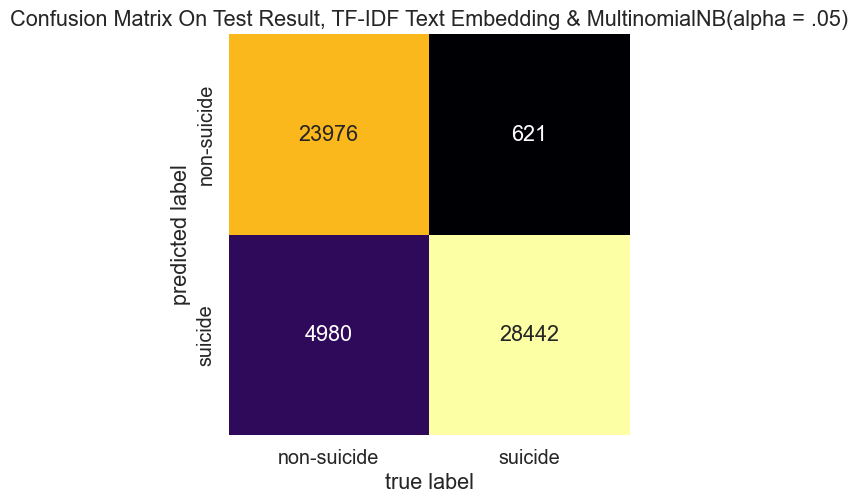

In [12]:
import seaborn as sns
sns.set()

cm_dc = confusion_matrix(y_test, nb_test_preds)
sns.set(font_scale=1.3)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-suicide','suicide'],yticklabels=['non-suicide','suicide']
            )
plt.tight_layout()
plt.title('Confusion Matrix On Test Result, TF-IDF Text Embedding & MultinomialNB(alpha = .05)')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

## Trials For Improving The Model

Note: Four different approaches have been tried in this section, including changes in model parameter, text preprocessing approach, dimension reduction in input data, and advanced word embedding.

## Trial 0: Adjust alpha (laplace smoothing parameter)

Result:
* The result shows that alpha = 0.03 gives a slightly better result, which can be seen from the increase in f1-score as well as test accuracy

In [13]:
# alpha = 0.07
nb_classifier = MultinomialNB(alpha = .07)

nb_classifier.fit(X_train, y_train)

nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

res = pd.concat([res, 
         pd.DataFrame([{"model":"Benchmark Model, alpha = 0.07",
            "accuracy":accuracy_score(y_test,nb_test_preds),
            "f1_score":f1_score(y_test,nb_test_preds)}])])

print(accuracy_score(y_train,nb_train_preds))
print(accuracy_score(y_test,nb_test_preds))
print(f1_score(y_test,nb_test_preds))

0.9826606532417914
0.90146331374205
0.9088037773772113


In [14]:
# alpha = 0.03
nb_classifier = MultinomialNB(alpha = .03)

nb_classifier.fit(X_train, y_train)

nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

res = pd.concat([res, 
         pd.DataFrame([{"model":"Benchmark Model, alpha = 0.03",
            "accuracy":accuracy_score(y_test,nb_test_preds),
            "f1_score":f1_score(y_test,nb_test_preds)}])])

print(accuracy_score(y_train,nb_train_preds))
print(accuracy_score(y_test,nb_test_preds))
print(f1_score(y_test,nb_test_preds))

0.9891241274309844
0.9039797307778487
0.9107569082899478


In [15]:
# alpha = 0.01
# When alpha = 0.01, model seems to overfit the test data
nb_classifier = MultinomialNB(alpha = .01)

nb_classifier.fit(X_train, y_train)

nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

res = pd.concat([res, 
         pd.DataFrame([{"model":"Benchmark Model, alpha = 0.01",
            "accuracy":accuracy_score(y_test,nb_test_preds),
            "f1_score":f1_score(y_test,nb_test_preds)}])])

print(accuracy_score(y_train,nb_train_preds))
print(accuracy_score(y_test,nb_test_preds))
print(f1_score(y_test,nb_test_preds))

0.9922208497314068
0.8975508023233768
0.90540755593749


## Trial 1: Adjust the pre-processing approach

* Instead of using a lemmatizer, use a stemming method when pre-processing the data

Result:
* Compared using accuracy and f1 score, lemmatizer gives a slightly better accuracy and f1 score compared with stemming.

In [16]:
from nltk.stem import *
stemmer = PorterStemmer()

def clean_text1(row):
    row = row.lower() # convert data into lower case
    row = re.sub(r"_",'', row) # remove hyphens
    row = re.sub(r'http\S+', '', row) #remove urls
    row = re.sub(r"(?<![@\w])@(\w{1,25})", '', row) #remove mentions
    row = re.sub(r"<[^>]+>", '', row) # remove carrot inserts from collection
    row = re.sub(r'[0-9]', '', row) # remove numbers
    row = tokenizer.tokenize(row)# Tokenize the row
    row = [w for w in row if w not in stopwords_list] # Remove stopwords
    row = [stemmer.stem(token) for token in row] # Lemmatize the words
    row = ' '.join(row)
    return row

data1 = copy.deepcopy(data)
data['text'] = data['text'].apply(clean_text1)

In [17]:
X1 = data.drop(columns = 'class')
y1 = data['class']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=20)

In [18]:
stopwords_list = stopwords.words('english')
tfidf = TfidfVectorizer(stop_words = stopwords_list,ngram_range = (1, 2))

tfidf_text_train1 = tfidf.fit_transform(X_train1['text'])
tfidf_text_test1 = tfidf.transform(X_test1['text'])

X_train1 = sparse.hstack([tfidf_text_train1]).tocsr()
X_test1 = sparse.hstack([tfidf_text_test1]).tocsr()

nb_classifier = MultinomialNB(alpha = .05)
nb_classifier.fit(X_train1, y_train1)

nb_train_preds1 = nb_classifier.predict(X_train1)
nb_test_preds1 = nb_classifier.predict(X_test1)

res = pd.concat([res, 
         pd.DataFrame([{"model":"Stemming, Benchmark model",
            "accuracy":accuracy_score(y_test,nb_test_preds1),
            "f1_score":f1_score(y_test,nb_test_preds1)}])])

print(accuracy_score(y_train1,nb_train_preds1))
print(accuracy_score(y_test1,nb_test_preds1))
print(f1_score(y_test1,nb_test_preds1))

0.9810864381948234
0.903531601716679
0.9103518972338347


## Trial 2: Use TruncatedSVD to reduce dimension on extracted features (Data preprocessed used the preprocessor with lemmatizer)

Result:
* The result from using tf-idf matrices for conducting dimension reduction is much better than using bow matrices, but generally speaking, naive bayes does not perform really well along with dimension reduction algorithm.
* The possible reason for the bad result is that: we lose informative information in dimension reduction process, in which we only keep 100 components and drop the rest. 

* There are a lot of features (words) in the input data, some of them are actually correlated with each other, and some other might be inrrelavant features. By conducting a dimension reduction on input data, we can remove the multicollinearity in input data and remove extraneous features, which might provide a better modedling result.
* TruncateSVD performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.
* text references: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
svd = TruncatedSVD(n_components = 100)

X = df.drop(columns = 'class')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

# Retrieve a bag of words representation using counter vectorizer first
bow_text_train = vectorizer.fit_transform(X_train['text'])
bow_text_test = vectorizer.transform(X_test['text'])

### Trial 2-1: Apply truncatedSVD on bow matrix

In [21]:
# Initiate the TruncatedSVD model
# According to the documentation, n_components = 100 is recommended for LSA analysis

X_train2_1 = svd.fit_transform(bow_text_train) 
X_test2_1 = svd.transform(bow_text_test) 

# Since there are negative values in the feature matrix, whose dimension has been reduced using TruncatedSVD
# Therefore, use MinMaxScaler to rescale the feature matrix
from sklearn.preprocessing import MinMaxScaler
X_train2_1 = MinMaxScaler().fit_transform(X_train2_1)
X_test2_1 = MinMaxScaler().fit_transform(X_test2_1)

In [22]:
# Conduct modeling using Naive Bayes Model
nb_classifier = MultinomialNB(alpha = .05)

nb_classifier.fit(X_train2_1, y_train)

nb_train_preds2_1 = nb_classifier.predict(X_train2_1)
nb_test_preds2_1 = nb_classifier.predict(X_test2_1)

res = pd.concat([res, 
         pd.DataFrame([{"model":"TruncatedSVD on bow, Benchmark model",
            "accuracy":accuracy_score(y_test,nb_test_preds2_1),
            "f1_score":f1_score(y_test,nb_test_preds2_1)}])])

print(accuracy_score(y_train,nb_train_preds2_1))
print(accuracy_score(y_test,nb_test_preds2_1))
print(f1_score(y_test,nb_test_preds2_1))

0.5080520525121369
0.506765025250349
0.03252307380235978


### Trial 2-2: Apply truncatedSVD on tf-idf matrix

* Using truncatedSVD on tf–idf matrices is recommended over raw frequency counts in an LSA/document processing setting. In particular, sublinear scaling and inverse document frequency should be turned on (sublinear_tf=True, use_idf=True) to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data.
* text references: https://scikit-learn.org/stable/modules/decomposition.html#truncated-singular-value-decomposition-and-latent-semantic-analysis

In [23]:
tfidf2_2 = TfidfVectorizer(stop_words = stopwords_list,ngram_range = (1, 2), sublinear_tf=True, use_idf=True)

tfidf_text_train2_2 = tfidf2_2.fit_transform(X_train['text'])
tfidf_text_test2_2 = tfidf2_2.transform(X_test['text'])

X_train2_2 = sparse.hstack([tfidf_text_train2_2]).tocsr()
X_test2_2 = sparse.hstack([tfidf_text_test2_2]).tocsr()

In [24]:
svd = TruncatedSVD(n_components = 100)
X_train2_2 = svd.fit_transform(tfidf_text_train) 
X_test2_2 = svd.transform(tfidf_text_test)

X_train2_2 = MinMaxScaler().fit_transform(X_train2_2)
X_test2_2 = MinMaxScaler().fit_transform(X_test2_2)

In [25]:
# Conduct modeling using Naive Bayes Model
nb_classifier = MultinomialNB(alpha = .05)

nb_classifier.fit(X_train2_2, y_train)

nb_train_preds2_2 = nb_classifier.predict(X_train2_2)
nb_test_preds2_2 = nb_classifier.predict(X_test2_2)

res = pd.concat([res, 
         pd.DataFrame([{"model":"TruncatedSVD on tf-idf, Benchmark model",
            "accuracy":accuracy_score(y_test,nb_test_preds2_2),
            "f1_score":f1_score(y_test,nb_test_preds2_2)}])])

print(accuracy_score(y_train,nb_train_preds2_2))
print(accuracy_score(y_test,nb_test_preds2_2))
print(f1_score(y_test,nb_test_preds2_2))

0.8128580046537014
0.8049259725262414
0.7832631175794713


### Trial 3: Use Word2Vec For Embedding

Result:
* Note: Due to the storage space limit of my laptop, only 1% of the original data is used for Word2Vec embedding and Naive Bayes Model
* The result is worse compared with the benchmark NB model that directly takes tf-dif as the input.
* Word2Vec highly relies on the context of the text that it is originally trained on. Here, the google-news-300 is used for training the Word2Vec model.
* However, the context of reddit posts might not be exactly the same as google-news-300, which means that there could be semantic biases in the dimensions of word2vec. This is a possible reason that leads to the unsatisfying result in this case.
* Another possible reason lies in the tremendous reduction in training and testing data (only 1% of the original data is used).

* Word2Vec learns the word association from a large corpus of text. It helps represent each distinct word with a particular list of numbers (vectors), which capture the semantic and syntactic qualities of words.
* Compared with tf-dif, Word2Vec is a more advanced word embedding techniques, which captures the linguistic contexts of words, and thus might better extract features of the original text.
* Text reference: https://en.wikipedia.org/wiki/Word2vec
* Word2Vec code references: https://thinkingneuron.com/how-to-classify-text-using-word2vec/

In [26]:
# Retrieve a pre-trained word2vec model based on google news data
import gensim.downloader as api
w2v_google_news = api.load('word2vec-google-news-300')

In [27]:
# My laptop doesn't have enough storage space to train a model using all of the original data :(
# Therefore, randomly select 1% of original data for training and testing the word2vec embedded model
# Make sure that the two classes are also balanced after randomly droppong the data
df0 = df.loc[df['class'] == 0]
df1 = df.loc[df['class'] == 1]

X0 = df0.drop(columns = 'class')
y0 = df0['class']
X1 = df1.drop(columns = 'class')
y1 = df1['class']

X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, random_state=20, test_size = 0.01)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=20, test_size = 0.01)

X_sub = pd.concat([X_test0, X_test1])
y_sub = pd.concat([y_test0, y_test1])

In [28]:
vectorizer = CountVectorizer(stop_words='english')

# Retrieve features name in the form of dataframe column name
X_sub_bow = vectorizer.fit_transform(X_sub['text'])
colnames = np.append(vectorizer.get_feature_names_out(), 'class')
WordsVocab = pd.DataFrame(columns = colnames).columns[:-1]

In [29]:
# Converting every reddit post word into a numeric vector
# For each word in the sentence, the numeric representation of the word will be extracted using w2v_google_news
# The sum of numeric representations of each word in the sentence represents the numeric value of the whole sentence
# Defining a function which takes text input and returns one vector for each sentence

def FunctionText2Vec(inpTextData):
    # Converting the text to numeric data
    X = vectorizer.transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Creating empty dataframe to hold sentences
    W2Vec_Data=pd.DataFrame()
    
    # Looping through each row for the data
    for i in range(CountVecData.shape[0]):
 
        # initiating a sentence with all zeros
        Sentence = np.zeros(300)
 
        # Looping thru each word in the sentence and if its present in 
        # the Word2Vec model then storing its vector
        for word in WordsVocab[CountVecData.iloc[i , :]>=1]:
            if word in w2v_google_news.key_to_index.keys():    
                Sentence=Sentence+w2v_google_news[word]
        # Appending the sentence to the dataframe
        # W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
        W2Vec_Data=pd.concat([W2Vec_Data, pd.DataFrame([Sentence])])

    return(W2Vec_Data)

In [30]:
W2Vec_Data=FunctionText2Vec(X_sub['text'])

# Conduct the train test split on the subset data
X_train3, X_test3, y_train3, y_test3 = train_test_split(W2Vec_Data[W2Vec_Data.columns].values, y_sub, random_state=20)

X_train3 = MinMaxScaler().fit_transform(X_train3)
X_test3 = MinMaxScaler().fit_transform(X_test3)

In [31]:
nb_classifier = MultinomialNB(alpha = .05)
nb_classifier.fit(X_train3, y_train3)

nb_train_preds3 = nb_classifier.predict(X_train3)
nb_test_preds3 = nb_classifier.predict(X_test3)

res = pd.concat([res, 
         pd.DataFrame([{"model":"1% Subset data, Word2Vec, Benchmark model",
            "accuracy":accuracy_score(y_test3,nb_test_preds3),
            "f1_score":f1_score(y_test3,nb_test_preds3)}])])

print(accuracy_score(y_train3,nb_train_preds3))
print(accuracy_score(y_test3,nb_test_preds3))
print(f1_score(y_test3,nb_test_preds3))

0.7294658242389431
0.7074010327022375
0.5971563981042654


## Report of Accuracy

* Accuracy is reported in the dataframe below
* Benchmark Model refers to the model that use tf-idf matrix as input and MultinomialNB(alpha = .05) as model
* There's increase in accuracy and f1_score when we alter the alpha of benchmark model to 0.03, while other tinkering methods provide worse results

In [32]:
res = res.reset_index(drop = True)
res

,model,accuracy,f1_score
0,Benchmark Model,0.903463,0.910362
1,"Benchmark Model, alpha = 0.07",0.901463,0.908804
2,"Benchmark Model, alpha = 0.03",0.903980,0.910757
3,"Benchmark Model, alpha = 0.01",0.897551,0.905408
4,"Stemming, Benchmark model",0.903532,0.910352
5,"TruncatedSVD on bow, Benchmark model",0.506765,0.032523
6,"TruncatedSVD on tf-idf, Benchmark model",0.804926,0.783263
7,"1% Subset data, Word2Vec, Benchmark model",0.707401,0.597156


## Challenges

* One challenge is related to the model. At very first I have the idea of trying out a dimension reduction technique on the input matrices. We've learned PCA in this semester, but it is not really applicable for the text data here. Therefore I searched online and learned about the Truncated SVD method, which uses similar idea of singular vector decomposition as PCA, but more applicable to text data, and is oftentimes used for semantic analysis. I learned the basic idea of the model and successfully applied it in my model. BUT I'm not really sure if it is a good idea to combine the dimension reduction techniques along with Naive Bayes model, future study is absolutely needed to fully understand the mathmatical logic and compatiability of these two models. 
* Another challenge I ran into was related to my data. The text data sometimes get extremely large that my laptop cannot handle it at all. For example, I tried to use the full data in Word2Vec section, but it takes around 200 GB to store the result! Therefore I only used a tiny subset of the text data to construct the whole model. Similar issue arises when I tried to keep more components in the Truncated SVD section. This issue was temporarily solved as I limited the scope to explore. Hopefully, I will get to run the full dataset on some much powerful machine and test some of my hypothesis. 

## Impacts

* Benefit 1: This model has positive social influences: If the input data is valid, this model can really help identify users with suicide tendancy on the social platform, and we can help these people get out of the idea of committing a suicide through some positive interference.
* Benefit 2: This model has potential economic influences as well: It can help create a more supportive environment on reddit, which, could potentially drive more users towards this platform.
* Harm1: The biggest concern of the model: the data source did not clearly specify how the suicide and non-suicide classes are classfied. If there's significant issue in the identifictaion of classes, the whole model will become "garbage in, garbage out".
* Harm2: Data Privacy issues are presented in this dataset, as we could reverse engineer who created these posts.

## Future Works

* Research Question: How can we further classify the suicide posts identified into different categoriees, so that we can have targetted help/ interference for these people?
* Importance: Posts related to suicide contains important informtion, for example, why they want to commit a suicide, where they are, how they attempt to kill themselves. By answering these questions and classify the suicide related post into different categories, we might porvide better help for these people. 